In [1]:
pip install pandas numpy matplotlib statsmodels xgboost scikit-learn openpyxl


Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install --upgrade openpyxl


  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/c0/da/977ded879c29cbd04de313843e76868e6e13408a94ed6b987245dc7c8506/openpyxl-3.1.5-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/250.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/250.9 kB ? eta -:--:--
   ------ -------------------------------- 41.0/250.9 kB 388.9 kB/s eta 0:00:01
   -------------- ------------------------ 92.2/250.9 kB 744.7 kB/s eta 0:00:01
   --------------------------- ------------ 174.1/250.9 kB 1.0 MB/s eta 0:00:01
   ---------------------------------------- 250.9/250.9 kB 1.2 MB/s eta 0:00:00
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.10
    Uninstalling openpyxl-3.0.10:
      Successfully uninstalled openpyxl-3.0.10


In [5]:
import openpyxl
print(openpyxl.__version__)


3.0.10


In [7]:
import pandas as pd

df = pd.read_csv(r'D:\a\a1.csv', sep=',')
print(df.head())
print(df.dtypes)


                             ;1;2
0  10.03.2025;2 275 648;4 390 106
1  10.02.2025;2 266 064;4 353 143
2  10.01.2025;2 260 035;4 328 500
3  10.12.2024;2 248 072;4 318 338
4  10.11.2024;2 235 353;4 272 963
;1;2    object
dtype: object


In [8]:
import pandas as pd

df = pd.read_csv(
    r'D:\a\a1.csv',
    sep=';',             # правильный разделитель
    thousands=' ',       # пробел как разделитель тысяч
    parse_dates=[0],     # распознать первую колонку как дату
    dayfirst=True        # день перед месяцем в формате даты
)

# Переименуем колонки
df.columns = ['ds', 'y1', 'y2']

# Проверим результат
print(df.head())
print(df.dtypes)


          ds       y1       y2
0 2025-03-10  2275648  4390106
1 2025-02-10  2266064  4353143
2 2025-01-10  2260035  4328500
3 2024-12-10  2248072  4318338
4 2024-11-10  2235353  4272963
ds    datetime64[ns]
y1             int64
y2             int64
dtype: object


C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

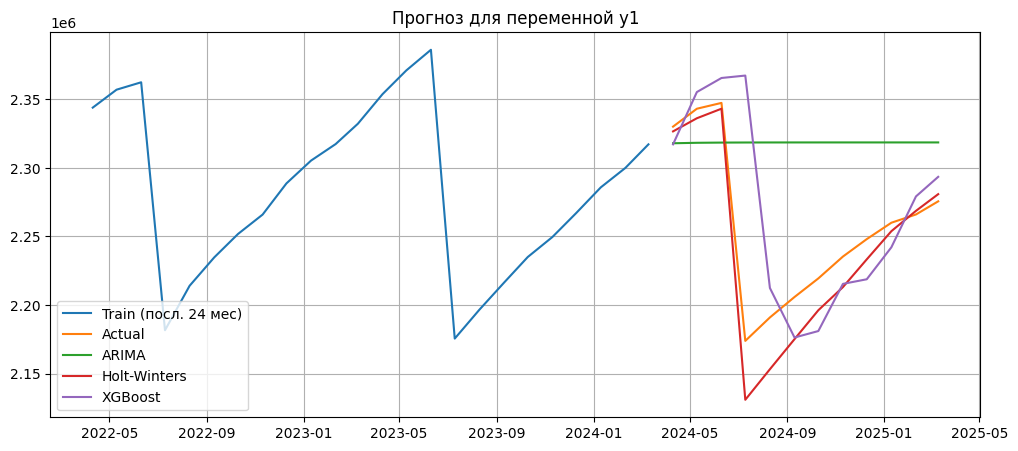

C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adeli\a

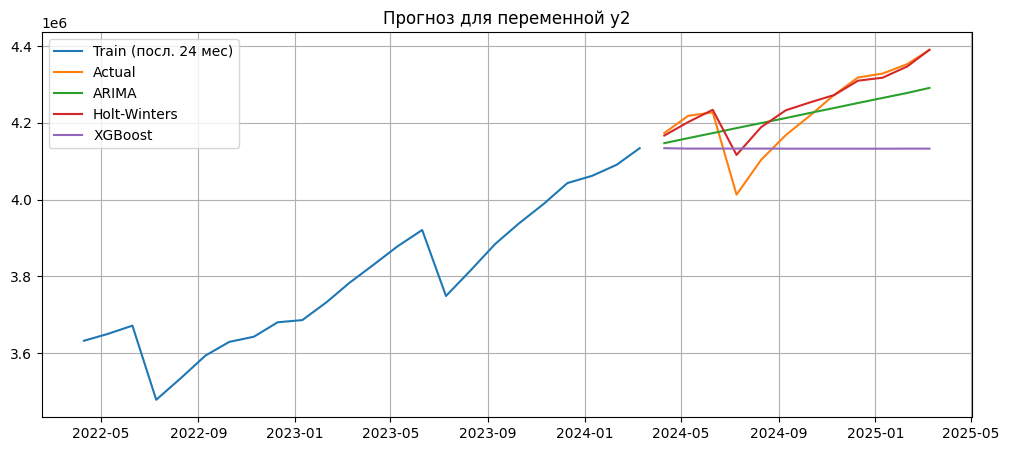

               Label            MAE           RMSE
y1_arima    ARIMA_y1   71538.523499   82361.532581
y1_holt      Holt_y1   16709.394113   21652.142965
y1_xgb    XGBoost_y1     35382.6875   59871.464825
y2_arima    ARIMA_y2   66525.224481   78198.474913
y2_holt      Holt_y2   28667.742151   44683.223571
y2_xgb    XGBoost_y2  124012.291667  143946.681202


In [10]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Загрузка CSV
df = pd.read_csv(
    r'D:\a\a1.csv',
    sep=';',
    thousands=' ',
    parse_dates=[0],
    dayfirst=True
)
df.columns = ['ds', 'y1', 'y2']
df = df.sort_values('ds')
df.set_index('ds', inplace=True)

# Разделение на train/test
train, test = df.iloc[:-12], df.iloc[-12:]
results = {}

# Метрики
def evaluate_models(y_true, y_pred, label):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "Label": label,
        "Forecast": y_pred
    }

# ARIMA с индексом
def forecast_arima(train_series, test_series):
    model = ARIMA(train_series, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_series))
    forecast.index = test_series.index  # <-- фикс
    return forecast

# Holt-Winters с индексом
def forecast_holt_winters(train_series, test_series):
    model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=12)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_series))
    forecast.index = test_series.index  # <-- фикс
    return forecast


# XGBoost
def create_lag_features(df, lags=12):
    df_lagged = df.copy()
    for lag in range(1, lags+1):
        df_lagged[f'lag_{lag}'] = df_lagged['y'].shift(lag)
    df_lagged['month'] = df_lagged.index.month
    return df_lagged.dropna()

def forecast_xgboost(train_df, test_index):
    data = create_lag_features(train_df)
    X = data.drop("y", axis=1)
    y = data["y"]
    model = XGBRegressor()
    model.fit(X, y)

    preds = []
    last = train_df.copy()

    for _ in range(len(test_index)):
        row = create_lag_features(last)[-1:].drop("y", axis=1)
        pred = model.predict(row)[0]
        preds.append(pred)
        new_date = last.index[-1] + pd.DateOffset(months=1)
        last.loc[new_date] = pred

    return pd.Series(preds, index=test_index)

# Общая функция прогноза
def process_variable(name):
    y_train = train[name]
    y_test = test[name]
    df_y = train[[name]].rename(columns={name: "y"})

    forecast_a = forecast_arima(y_train, y_test)
    forecast_h = forecast_holt_winters(y_train, y_test)
    forecast_x = forecast_xgboost(df_y, test.index)

    results[f'{name}_arima'] = evaluate_models(y_test, forecast_a, f'ARIMA_{name}')
    results[f'{name}_holt'] = evaluate_models(y_test, forecast_h, f'Holt_{name}')
    results[f'{name}_xgb'] = evaluate_models(y_test, forecast_x, f'XGBoost_{name}')

    # Визуализация
    plt.figure(figsize=(12, 5))
    plt.plot(train[name][-24:], label='Train (посл. 24 мес)')
    plt.plot(y_test, label='Actual')
    plt.plot(forecast_a, label='ARIMA')
    plt.plot(forecast_h, label='Holt-Winters')
    plt.plot(forecast_x, label='XGBoost')
    plt.title(f'Прогноз для переменной {name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Запуск
process_variable('y1')
process_variable('y2')

# Таблица метрик
res_df = pd.DataFrame(results).T[["Label", "MAE", "RMSE"]]
print(res_df)


C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

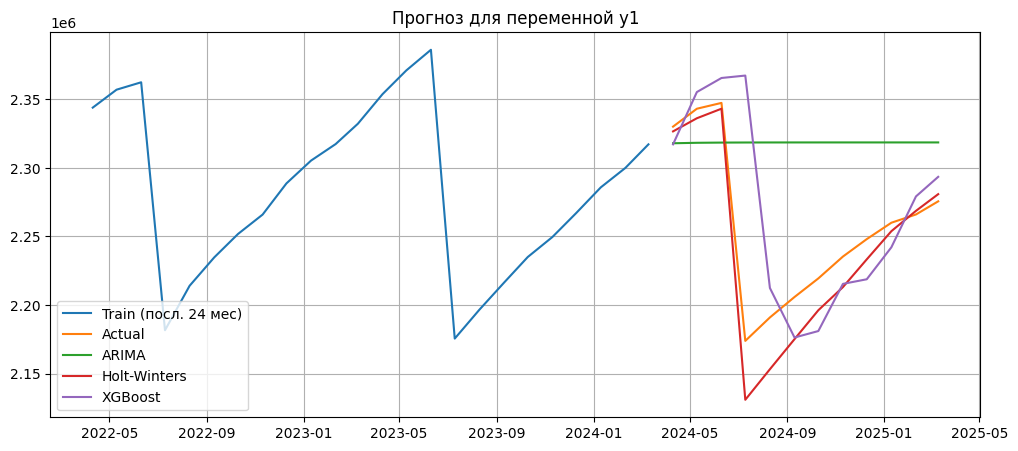

C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\adeli\a

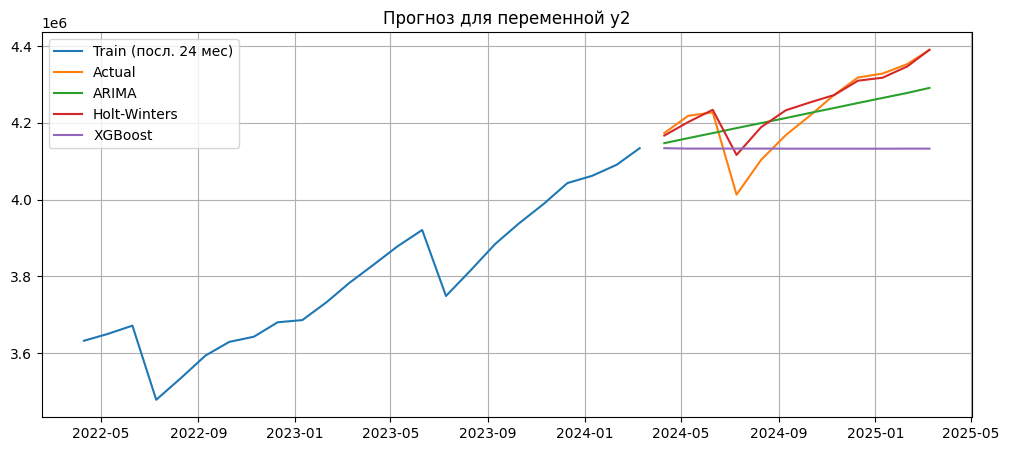

,Label,MAE,RMSE,R2,MAPE (%),SMAPE (%),MASE
y1_arima,ARIMA_y1,"71,538.52","82,361.53",-1.18,3.21,3.15,1.93
y1_holt,Holt_y1,"16,709.39","21,652.14",0.85,0.75,0.76,0.45
y1_xgb,XGBoost_y1,"35,382.69","59,871.46",-0.15,1.60,1.57,0.95
y2_arima,ARIMA_y2,"66,525.22","78,198.47",0.44,1.58,1.58,1.76
y2_holt,Holt_y2,"28,667.74","44,683.22",0.82,0.70,0.69,0.76
y2_xgb,XGBoost_y2,"124,012.29","143,946.68",-0.91,2.90,2.95,3.28


In [11]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Загрузка CSV
df = pd.read_csv(
    r'D:\a\a1.csv',
    sep=';',
    thousands=' ',
    parse_dates=[0],
    dayfirst=True
)
df.columns = ['ds', 'y1', 'y2']
df = df.sort_values('ds')
df.set_index('ds', inplace=True)

# Train/test
train, test = df.iloc[:-12], df.iloc[-12:]
results = {}

# Метрики
def mase(y_true, y_pred, y_train):
    naive = y_train.shift(1).dropna()
    naive_err = np.mean(np.abs(naive.values - y_train[1:].values))
    model_err = np.mean(np.abs(y_true - y_pred))
    return model_err / naive_err if naive_err != 0 else np.nan

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def evaluate_models(y_true, y_pred, label, y_train=None):
    return {
        "Label": label,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred),
        "MAPE (%)": np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        "SMAPE (%)": smape(y_true, y_pred),
        "MASE": mase(y_true, y_pred, y_train) if y_train is not None else np.nan,
        "Forecast": y_pred
    }

# ARIMA
def forecast_arima(train_series, test_series):
    model = ARIMA(train_series, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_series))
    forecast.index = test_series.index
    return forecast

# Holt-Winters
def forecast_holt_winters(train_series, test_series):
    model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=12)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_series))
    forecast.index = test_series.index
    return forecast

# XGBoost
def create_lag_features(df, lags=12):
    df_lag = df.copy()
    for lag in range(1, lags+1):
        df_lag[f'lag_{lag}'] = df_lag['y'].shift(lag)
    df_lag['month'] = df_lag.index.month
    return df_lag.dropna()

def forecast_xgboost(train_df, test_index):
    data = create_lag_features(train_df)
    X = data.drop("y", axis=1)
    y = data["y"]
    model = XGBRegressor()
    model.fit(X, y)

    preds = []
    last = train_df.copy()

    for _ in range(len(test_index)):
        row = create_lag_features(last)[-1:].drop("y", axis=1)
        pred = model.predict(row)[0]
        preds.append(pred)
        new_date = last.index[-1] + pd.DateOffset(months=1)
        last.loc[new_date] = pred

    return pd.Series(preds, index=test_index)

# Прогноз по переменной
def process_variable(name):
    y_train = train[name]
    y_test = test[name]
    df_y = train[[name]].rename(columns={name: "y"})

    forecast_a = forecast_arima(y_train, y_test)
    forecast_h = forecast_holt_winters(y_train, y_test)
    forecast_x = forecast_xgboost(df_y, test.index)

    results[f'{name}_arima'] = evaluate_models(y_test, forecast_a, f'ARIMA_{name}', y_train)
    results[f'{name}_holt'] = evaluate_models(y_test, forecast_h, f'Holt_{name}', y_train)
    results[f'{name}_xgb'] = evaluate_models(y_test, forecast_x, f'XGBoost_{name}', y_train)

    # График
    plt.figure(figsize=(12, 5))
    plt.plot(train[name][-24:], label='Train (посл. 24 мес)')
    plt.plot(y_test, label='Actual')
    plt.plot(forecast_a, label='ARIMA')
    plt.plot(forecast_h, label='Holt-Winters')
    plt.plot(forecast_x, label='XGBoost')
    plt.title(f'Прогноз для переменной {name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Запуск по y1 и y2
process_variable('y1')
process_variable('y2')

# Вывод всех метрик
res_df = pd.DataFrame(results).T.drop(columns='Forecast')
pd.options.display.float_format = '{:,.2f}'.format
display(res_df)


In [12]:
# Срок прогноза: до января 2028 года
forecast_horizon_months = (2028 - df.index.max().year) * 12 + (1 - df.index.max().month)
future_index = pd.date_range(df.index.max() + pd.DateOffset(months=1), periods=forecast_horizon_months, freq='MS')

# Прогноз с Holt-Winters по y1
hw_model_y1 = ExponentialSmoothing(df['y1'], trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_y1 = hw_model_y1.forecast(forecast_horizon_months)
forecast_y1.index = future_index

# Прогноз с Holt-Winters по y2
hw_model_y2 = ExponentialSmoothing(df['y2'], trend='add', seasonal='add', seasonal_periods=12).fit()
forecast_y2 = hw_model_y2.forecast(forecast_horizon_months)
forecast_y2.index = future_index

# Целевые даты
target_dates = pd.to_datetime(['2026-01-10', '2027-01-10', '2028-01-10'])

# Подбор ближайших дат в прогнозе
result = pd.DataFrame({
    'Дата': target_dates,
    'y1 (прогноз)': [forecast_y1.asof(date) for date in target_dates],
    'y2 (прогноз)': [forecast_y2.asof(date) for date in target_dates]
})

# Вывод
print(result.to_string(index=False))


C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_

      Дата  y1 (прогноз)  y2 (прогноз)
2026-01-10  2,212,295.35  4,591,906.41
2027-01-10  2,184,108.70  4,855,989.42
2028-01-10  2,155,922.05  5,120,072.43


C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\adeli\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
